# Stock Market News and Sentiment Analysis Backtesting

In [1]:
# Libraries
from eod import EodHistoricalData
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import nltk
from textblob import TextBlob
import numpy as np
import random
import plotly.express as px


# Importing and assigning the api key
with open("../../eodHistoricalData-API.txt", "r") as f:
    api_key = f.read()
    
# EOD Historical Data client
client = EodHistoricalData(api_key)

## Retrieving News & Price History

In [2]:
def getNewsAndPrices(ticker, days):
    """
    Retrieves financial news over the course of a specified number of days for
    a given stock ticker.
    """

    # List of news
    news = []
    
    # How many days back to retrieve
    ago = datetime.now() - timedelta(days=days)

    # Getting news over the course of a year
    for i in tqdm(range(10, days, 10)):

        # Grabbing the news
        resp = client.get_financial_news(
            s=ticker,
            from_=(ago+timedelta(days=i-10)).strftime("%Y-%m-%d"),
            to=(ago+timedelta(days=i)).strftime("%Y-%m-%d"),
            limit=100
        )

        # Adding to the news list
        news.extend(resp)
        
    # Filtering out irrelevant news
    lst = [i for i in news if sum(x in {ticker.lower()} for x in nltk.word_tokenize(i['title'].lower()))>=1]
    
    # Formatting the date
    news = pd.DataFrame(lst)
    
    news['date'] = news['date'].apply(lambda x: x[:10])
    
    # Getting prices
    prices = pd.DataFrame(client.get_prices_eod(ticker, from_=ago.strftime("%Y-%m-%d")))
    
    # Set index
    prices = prices.set_index('date', drop=True)
    
    return news, prices

In [11]:
# Retrieving financial news and price history
news, prices = getNewsAndPrices("TSLA", 400)

100%|██████████| 39/39 [00:53<00:00,  1.36s/it]


In [12]:
news

,date,title,content,link,symbols,tags
0,2020-12-26,Why Tesla’s Rivals Are Looking Better Than TSL...,"In past years, I used to believe that Tesla (N...",https://finance.yahoo.com/news/why-tesla-rival...,"[BB.US, TSLA.US, F.US, SOLO.US, AYRO.US]","[TESLA, TESLA STOCK, ELON MUSK, MARKET SHARE, ..."
1,2021-01-18,"Auto Stock Roundup: TSLA's India Entry, F's So...","Last week, China’s 2020 auto sales data was re...",https://finance.yahoo.com/news/auto-stock-roun...,"[TSLA.US, GM.US, F.US, KMX.US, NAV.US, KMX.MX]","[CHINA, INDIA, GENERAL MOTORS, MANUFACTURING F..."
2,2021-02-01,"Auto Stock Roundup: Biden's Big EV Push, TSLA ...","Last week, U.S. President Biden pledged to pha...",https://finance.yahoo.com/news/auto-stock-roun...,"[TSLA.US, GM.US, PCAR.US, OSK.US, ALV.US, LIV.F]","[ZACKS RANK, GENERAL MOTORS, ZACKS CONSENSUS E..."
3,2021-03-25,Tesla (TSLA) Outpaces Stock Market Gains: What...,Tesla (TSLA) closed the most recent trading da...,https://finance.yahoo.com/news/tesla-tsla-outp...,"[TSLA.US, GSPC.INDX, TSLA34.SA]","[TESLA, ZACKS RANK, ESTIMATE REVISIONS, TSLA]"
4,2021-04-01,Tesla (TSLA) Stock Sinks As Market Gains: What...,Tesla (TSLA) closed the most recent trading da...,https://finance.yahoo.com/news/tesla-tsla-stoc...,"[TSLA.US, GSPC.INDX, TSLA34.SA]","[TESLA, ZACKS RANK, TSLA]"
...,...,...,...,...,...,...
79,2021-10-21,Tesla (TSLA) Q3 Earnings &amp; Sales Top Estim...,Tesla TSLA reported third-quarter 2021 earning...,https://finance.yahoo.com/news/tesla-tsla-q3-e...,"[TSLA.US, F.US, FDMO34.SA, TSLA34.SA, TL0.XETR...","[TESLA, REPORTED QUARTER, OPERATING MARGIN, GR..."
80,2021-10-29,HOG vs. TSLA: Which Stock Should Value Investo...,Investors looking for stocks in the Automotive...,https://finance.yahoo.com/news/hog-vs-tsla-sto...,"[TSLA.US, HOG.US, TSLA34.SA, TL0.XETRA, TL0.F,...","[ZACKS RANK, EARNINGS ESTIMATE, STRONG BUY, PE..."
81,2021-11-10,Tesla (TSLA) Rout Continues,"Tesla stock continued its plunge, falling by 1...",https://finance.yahoo.com/m/1f071b0e-f9bb-3097...,"[TSLA.US, NVDA.US, NVDC34.SA, TSLA34.SA, TL0.X...","[TESLA, TESLA STOCK, TESLA SHARES, MUSK, KIMBA..."
82,2021-11-18,Has Tesla (TSLA) Outpaced Other Auto-Tires-Tru...,Investors interested in Auto-Tires-Trucks stoc...,https://finance.yahoo.com/news/tesla-tsla-outp...,"[TSLA.US, TSLA34.SA, TL0.XETRA, TL0.F, TSLA.MX]","[TESLA, ZACKS INVESTMENT RESEARCH, ZACKS RANK,..."


## Sentiment Positions Function

In [13]:
def sentimentPositions(val, thresh=0.1):
    """
    Returns position as 1, -1, or 0 for Buy, Sell, 
    and Do Nothing respectively based on the given 
    sentiment value and threshold.
    """
    if val > thresh:
        return 1
    elif val< -thresh:
        return -1
    else:
        return 0

# Sentiment Analysis

In [14]:
# Getting sentiment values for the news headlines/titles
news['sentiment'] = news['title'].apply(
    lambda x: TextBlob(x.lower()).sentiment[0]
)

# Grouping together dates and aggregating sentiment scores from the same day
df = news.groupby('date')[['sentiment']].mean()

# Applying the position function
df['sentiment_positions'] = df['sentiment'].apply(
    lambda x: sentimentPositions(x, thresh=0)
)

# Combining Prices and Sentiment

In [15]:
# Merging price history and sentiment positions
df = df.merge(
    prices, 
    right_index=True, 
    left_index=True, 
    how='outer'
)

# Filling in empty values with their most recent value for positions
df['sentiment_positions'] = df['sentiment_positions'].fillna(
    method='ffill'
)

# Backtesting

In [16]:
# Positions shifted ahead by one to compensate for lookahead bias
position_df = df[['sentiment_positions']].shift(1)

# Buy and hold strategy
position_df['buy&hold'] = 1

# Random strategy
position_df['random_positions'] = random.choices(
    [1,0,-1], k=len(position_df)
)

# Dropping the last Nans
position_df = position_df.dropna()

position_df

,sentiment_positions,buy&hold,random_positions
date,,,
2020-12-28,1.0,1,-1
2020-12-29,1.0,1,0
2020-12-30,1.0,1,0
2020-12-31,1.0,1,1
2021-01-04,1.0,1,0
...,...,...,...
2021-11-23,0.0,1,0
2021-11-24,0.0,1,1
2021-11-26,0.0,1,-1


## Performing the Backtest

In [17]:
# Log returns
log_returns = df['adjusted_close'].apply(
    np.log
).diff()

# Performing the backtest
returns = position_df.multiply(
    log_returns, 
    axis=0
)

# Inversing the log returns to get daily portfolio balance
performance = returns.cumsum().apply(
    np.exp
).dropna().fillna(
    method='ffill'
)

# Visualizing Results

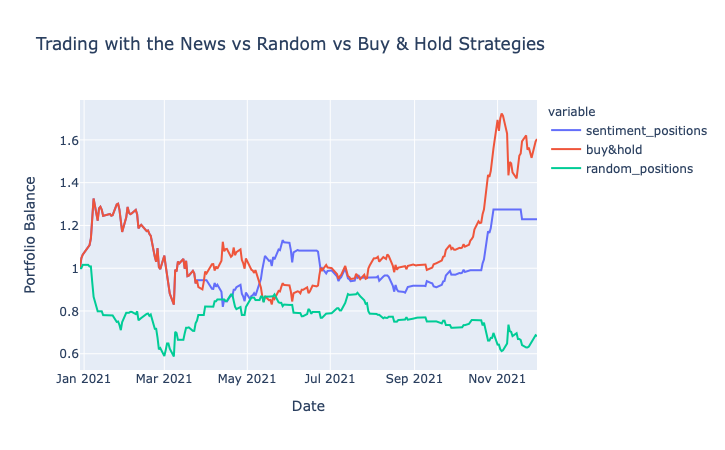

In [18]:
# Visualizing results
fig = px.line(
    performance,
    x=performance.index,
    y=performance.columns,
    title='Trading with the News vs Random vs Buy & Hold Strategies',
    labels={"value": "Portfolio Balance",
            "date": "Date"}
)

fig.show()